<div class="alert alert-block alert-info">
<b>Deadline:</b> May 03, 2023 (Wednesday) 23:00
</div>

# Exercise 3. Variational autoencoders

The goal of this exercise is to get familiar with *variational* autoencoders. The model was presented by [Kigma and Welling, 2013](https://arxiv.org/pdf/1312.6114.pdf).

In [52]:
skip_training = True  # Set this flag to True before validation and submission

In [53]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [54]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [55]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [56]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [57]:
# The models are always evaluated on CPU
if skip_training:
    device = torch.device("cpu")

# Data

In this exercise, we will use the same varianceMNIST dataset from notebook 2.

In [58]:
# We will use varianceMNIST data in this exercise
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Lambda(lambda x: x * torch.randn_like(x))
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

We visualize some random training samples in the cell below. As you can see, we can quite easily recognize the digits.

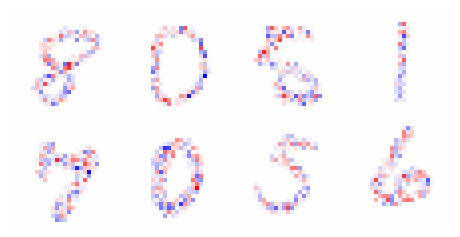

In [59]:
images, labels = next(iter(trainloader))
tools.show_images(images[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])

# Variational autoencoder (VAE)

In this exercise, we will assume the following generative model for the data:
* the latent codes are normally distributed:
$$
  p(z) = \mathcal{N}(z \mid 0, I)
$$
where $I$ is the identity matrix.
* the data are produced from the latent codes as follows:
$$
  p(x \mid z) =\mathcal{N}\left(x \mid \mu_x(z), \:\text{diag}(\sigma^2_x(z)) \right)
$$
where $\mu_x(z)$ and $\sigma^2_x(z)$ are some deterministic functions that we need to learn.

## Encoder

In the cell below, your task is to implement the encoder of a VAE.
The proposed architecture of the encoder is similar to the encoder from notebook 2:
* `Conv2d` layer with kernel size 5 with 6 output channels, followed by ReLU
* `Conv2d` layer with kernel size 5 with 16 output channels, followed by ReLU
* Fully-connected layer with 250 output features, followed by ReLU
* Two heads: each is a fully-connected layer with `n_components` elements.

The two heads are needed to produce two outputs of the encoder:
* means $\mu_z$ of the approximate distribution of the latent code $\bar z$
* log-variance $\tilde z$ of the approximate distribution of the latent code $z$.
To guarantee that the variance is positive, we parameterize it as $\sigma_z^2 = \exp(\tilde z)$.

Note: The exact architecture is not tested in this notebook.

In [60]:
class Encoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in produced codes.
        """
        # YOUR CODE HERE
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(16*20*20,250)
        self.relu3 = nn.ReLU()
        
        self.h1 = nn.Linear(250,n_components)
        self.h2 = nn.Linear(250,n_components)
        # Commented by myself - raise NotImplementedError()
        
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, n_channels=1, width, height): Examples to encode.

        Returns:
          z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
          z_logvar of shape (batch_size, n_components): Log-variances of the approximate distributions of the codes.
        """
        # YOUR CODE HERE
        z = self.relu1(self.conv1(x))        
        z = self.relu2(self.conv2(z))
        z = torch.flatten(z, 1, -1)
        z = self.relu3(self.fc3(z))
        z_mean = self.h1(z)
        z_logvar = self.h2(z)
        return z_mean, z_logvar
        # Commented by myself - raise NotImplementedError()

    def sample(self, z_mean, z_logvar):
        """Draw one sample from the posterior of the latent codes described by given parameters.
        This is needed for the re-parameterization trick.
        
        Args:
          z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
          z_logvar of shape (batch_size, n_components): Log-variance of the approximate distributions of the codes.
        
        Returns:
          z of shape (batch_size, n_components): Drawn samples.
        """
        # YOUR CODE HERE
        std = torch.sqrt(torch.exp(z_logvar))
        eps = torch.randn_like(std)
        z = z_mean + eps*std
        return z
        # Commented by myself - raise NotImplementedError()

In [61]:
def test_Encoder_shapes():
    n_components = 10 # dimensional latent space
    encoder = Encoder(n_components=n_components)

    x = torch.randn(3, 1, 28, 28)
    mu, logsigma = encoder(x)
    assert mu.shape == torch.Size([3, n_components]), f"Bad mu.shape: {mu.shape}"
    assert logsigma.shape == torch.Size([3, n_components]), f"Bad logsigma.shape: {logsigma.shape}"
    print('Success')

test_Encoder_shapes()

Success


In [62]:
def test_Encoder_sample():
    n_components = 10 # dimensional latent space
    encoder = Encoder(n_components=n_components)

    z_mean = torch.zeros(3, n_components)
    z_logvar = torch.log(2*torch.ones(3, n_components))
    z = encoder.sample(z_mean, z_logvar)
    assert z.shape == z_mean.shape, f"Bad z.shape: {z.shape}"
    print('Success')

test_Encoder_sample()

Success


### Kullback-Leibler divergence loss

One term of the loss function minimized during training of a VAE is the Kullback-Leibler divergence between the approximate distribution of the latent codes $q(z) = \mathcal{N}(z \mid \mu_z, \sigma^2_z)$ and the prior distribution $p(z) = \mathcal{N}(z \mid 0, I)$:
$$
\frac{1}{N} \sum_{i=1}^N \int q(z_i) \log \frac{q(z_i)}{p(z_i)} dz_i
$$
where $N$ is the number of samples (batch size in our implementation).

We will implement this loss function in the cell below.

Note: Please do **not** use functions from `torch.distributions` module. 

In [63]:
def loss_kl(z_mean, z_logvar):
    """
    Args:
      z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
      z_logvar of shape (batch_size, n_components): Log-variance of the approximate distributions of the codes.
    
    Returns:
      loss (torch scalar): Kullback-Leibler divergence.
    """
    # YOUR CODE HERE
    z_mean, z_logvar = z_mean.to(device), z_logvar.to(device)
    loss = (-0.5*torch.sum(1 + z_logvar - z_mean * z_mean - torch.exp(z_logvar), dim=-1)).mean()
    # Commented by myself - raise NotImplementedError()
    return loss

In [64]:
def test_loss_kl():
    n_components = 3
    z_mean = torch.zeros(3, n_components)
    z_logvar = torch.log(2*torch.ones(3, n_components))
    loss = loss_kl(z_mean, z_logvar)
    expected = torch.tensor(0.4602792263031006)
    print('loss:', loss.item())
    print('expected:', expected.item())
    assert torch.allclose(loss, expected, atol=1e-5), "loss does not match expected value."
    print('Success')

test_loss_kl()

loss: 0.4602792263031006
expected: 0.4602792263031006
Success


## Decoder

The decoder computes the predictive distribution of the data given latent code $z$ according to our
assumed generative model:
$$
  p(x \mid z) = \mathcal{N}\left(x \mid \mu_x(z), \sigma^2_x(z) \right)
$$
where $\mu_x(z)$ and $\sigma^2_x(z)$ are some deterministic functions that we need to learn.

The proposed architecture of the decoder is similar to the one from notebook 2:
* Fully-connected layer with 250 output features, followed by ReLU
* Fully-connected layer with 250 input features, followed by ReLU
* `ConvTranspose2d` layer with kernel size 5 with 16 input channels, followed by ReLU
* Two heads made of `ConvTranspose2d` layer with kernel size 5 with 6 input channels.

The two heads are needed to produce two outputs of the decoder:
* means $\mu_x$ of the predictive distribution of the data
* log-variance $\tilde x$ of the predictive distribution of the data.
To guarantee that the variance is positive, we parameterize it as $\sigma_x^2 = \exp(\tilde x)$.

**Important:**

In practice, learning the proposed generative model is difficult for the varianceMNIST dataset. The problem is that the background pixels have zero variances, which corresponds to infinitely low loss values. Thus, training may concentrate entirely on modeling the variance of the background pixels. To prevent this, we define the minimum allowed value of the predictive variance $\tilde x$ and save it in the model as
```
    self.register_buffer('min_logvar', -6 * torch.ones(1))
```
We need to use `register_buffer` to make sure that the variable is on the same device as the trained parameters of the model. We can use this code in the forward function to limit the predicted variance by `self.min_logvar`:
```
logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)
```

In [65]:
class Decoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in input codes.
        """
        # YOUR CODE HERE
        super(Decoder, self).__init__()
        self.decoder1 = nn.Sequential(
            nn.Linear(n_components, 250),
            nn.ReLU(),
            nn.Linear(250, 6400),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 6, 5),
            nn.ReLU(),
        )
        self.head1 = nn.ConvTranspose2d(6, 1, 5)
        self.head2 = nn.ConvTranspose2d(6, 1, 5)       
        self.register_buffer('min_logvar', -6 * torch.ones(1))
        # Commented by myself - raise NotImplementedError()

    def forward(self, z):
        """
        Args:
          z of shape (batch_size, n_components): Input codes.

        Returns:
          y_mean of shape (batch_size, n_channels=1, width, height): Means of the probability distributions
              describing the data examples that correspond to the given codes.
          y_logvar of shape (batch_size, n_channels=1, width, height): Log-variances of the probability
              distributions describing the data examples that correspond to the given codes.
        """
        # YOUR CODE HERE
        z = z.to(device)
        self = self.to(device)
        decoderOut = self.decoder1(z)
        decoderOut = decoderOut.view(decoderOut.shape[0], 16, 20, 20)
        decoderOut = self.decoder2(decoderOut)
        y_mean, y_logvar = self.head1(decoderOut), self.head2(decoderOut)
        y_logvar = self.min_logvar + F.softplus(y_logvar - self.min_logvar)
        return y_mean, y_logvar
        # Commented by myself - raise NotImplementedError()

In [66]:
def test_Decoder_shapes():
    n_components = 10 # dimensional latent space
    decoder = Decoder(n_components=n_components)

    z = torch.randn(3, n_components)
    y_mean, y_logvar = decoder(z)
    y_shape = torch.Size([3, 1, 28, 28])
    assert y_mean.shape == y_shape, "Bad shape of y_mean: y_mean.shape={}".format(y_mean.shape)
    assert y_logvar.shape == y_shape, "Bad shape of y_logvar: y_logvar.shape={}".format(y_logvar.shape)
    print('Success')

test_Decoder_shapes()

Success


### Expected log-likelihood term

The second term of the VAE loss function is minus log-likelihood estimated using sample $z_i$ from the approximate distribution $q(z_i)$ of the latent code that corresponds to training example $x_i$.

$$
- \int q(z_i) \log \mathcal{N}\left(x_i \mid \mu_x(z_i), \:\text{diag}(\sigma^2_x(z_i))\right) dz_i
$$
where $\mathcal{N}(x_i)$ is a multivariate normal distribution over all pixel values of image $x_i$.

Your task is to implement that function **without** constant terms
$$
\frac{28 \cdot 28}{2} \log 2 \pi
$$
that do not depend on $\mu_x(z_i)$ or $\sigma_x(z_i)$.

Note that $\mathcal{N}\left(x_i \mid \mu_x(z_i), \:\text{diag}(\sigma^2_x(z_i))\right)$ is a multivariate normal distribution with a **diagonal** covariance matrix. The fact that the covariance matrix is diagonal simplifies the computations a lot.

In [67]:
def loss_loglik(y_mean, y_logvar, x):
    """
    Args:
      y_mean of shape (batch_size, 1, 28, 28): Predictive mean of the VAE reconstruction of x.
      y_logvar of shape (batch_size, 1, 28, 28): Predictive log-variance of the VAE reconstruction of x.
      x of shape (batch_size, 1, 28, 28): Training samples.
    
    Returns:
      loss (torch scalar): Expected log-likelihood loss.
    """
    # YOUR CODE HERE
    batch_size = x.shape[0]
    std = torch.sqrt(torch.exp(y_logvar))
    loss = (torch.sum((torch.log(std) + 0.5 * ((x - y_mean).pow(2) / std.pow(2)))))/batch_size
    return loss
    # Commented by myself - raise NotImplementedError()

In [68]:
def test_loss_loglik():
    y_mean = torch.ones(3, 1, 28, 28) 
    y_logvar = torch.log(2*torch.ones(3, 1, 28, 28))
    y_logvar[:,:,:14,:] = torch.log(torch.ones(1, 1, 14, 28))

    x = torch.zeros(3, 1, 28, 28)
    x[:,:,:14,:] = torch.ones(3, 1, 14, 28)

    loss = loss_loglik(y_mean, y_logvar, x)
    expected = torch.tensor(233.8568572998047)
    
    print('loss:', loss)
    print('expected:', expected)
    assert torch.allclose(loss, expected), "loss does not match expected value."
    print('Success')

test_loss_loglik()

loss: tensor(233.8569)
expected: tensor(233.8569)
Success


# Train a variational autoencoder

In [69]:
# Create a variational autoencoder
n_components = 10 # dimensional latent space
encoder = Encoder(n_components=n_components)
decoder = Decoder(n_components=n_components)

encoder = encoder.to(device)
decoder = decoder.to(device)

### Training loop

Implement the training loop in the cell below. One iteration of the training loop process one mini-batch of data in the following way:
* The encoder is used to compute approximate distributions $q(z)$ of the latent codes corresponding to the training samples.
* One sample $z_i$ is drawn from each approximate posterior $q(z)$ (use function `Encoder.sample()` for that).
* The decoder uses samples $z_i$ to compute the predictive distribution for the training examples.
* The minimized loss is the sum of the KL-divergence loss `loss_kl()` and the expected log-likelihood loss `loss_loglik()` defined earlier.

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 10

Hints:
- The loss at convergence should be close to -1760.

In [70]:
# Training loop
if not skip_training:
    # YOUR CODE HERE
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.001)
    n_epochs = 5
    LOSS = []
    for _ in range(n_epochs):
        l_loss = []
        i = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            images = images.to(device)
            z_mean, z_logvar = encoder(images)
            z = encoder.sample(z_mean, z_logvar)
            y_mean, y_logvar = decoder(z)
            loss = loss_kl(z_mean, z_logvar) + loss_loglik(y_mean, y_logvar, images)
            loss.backward()
            l_loss.append(loss.item())
            print(i,len(trainloader),l_loss[-1])
            i += 1
            optimizer.step()
        LOSS.append(np.mean(l_loss))
        print('Loss',_,':',LOSS[-1])
    # Commented by myself - raise NotImplementedError()

0 1875 46.2727165222168
1 1875 29.135658264160156
2 1875 -5.453452110290527
3 1875 -32.075809478759766
4 1875 -64.23616027832031
5 1875 -91.08126831054688
6 1875 -105.83149719238281
7 1875 -120.58296203613281
8 1875 -143.6253204345703
9 1875 -168.2823944091797
10 1875 -184.85073852539062
11 1875 -208.64376831054688
12 1875 -209.8632049560547
13 1875 -198.4036102294922
14 1875 -213.19593811035156
15 1875 -290.1099853515625
16 1875 -258.2941589355469
17 1875 -290.03759765625
18 1875 -266.2790832519531
19 1875 -232.9076385498047
20 1875 -319.1673278808594
21 1875 -327.85028076171875
22 1875 -346.70306396484375
23 1875 -367.6022033691406
24 1875 -365.86334228515625
25 1875 -378.8981018066406
26 1875 -401.4823303222656
27 1875 -428.79815673828125
28 1875 -451.07000732421875
29 1875 -455.25421142578125
30 1875 -471.4766845703125
31 1875 -410.3138427734375
32 1875 -444.59881591796875
33 1875 -488.5689392089844
34 1875 -494.9925842285156
35 1875 -515.7513427734375
36 1875 -541.181396484375
37 

299 1875 -1262.7452392578125
300 1875 -1352.551025390625
301 1875 -1201.519287109375
302 1875 -1228.3841552734375
303 1875 -1364.677001953125
304 1875 -1430.160888671875
305 1875 -1376.7645263671875
306 1875 -1303.426513671875
307 1875 -1172.4298095703125
308 1875 -1308.47509765625
309 1875 -1239.117919921875
310 1875 -1263.0655517578125
311 1875 -1263.7032470703125
312 1875 -1195.9134521484375
313 1875 -1252.797607421875
314 1875 -1291.22900390625
315 1875 -1242.0869140625
316 1875 -1328.6651611328125
317 1875 -1216.540283203125
318 1875 -1232.5767822265625
319 1875 -1274.84228515625
320 1875 -1324.7481689453125
321 1875 -1277.157958984375
322 1875 -1269.541748046875
323 1875 -1274.181884765625
324 1875 -1298.1212158203125
325 1875 -1341.1944580078125
326 1875 -1287.010986328125
327 1875 -1317.77978515625
328 1875 -1394.009033203125
329 1875 -1309.5810546875
330 1875 -1298.088623046875
331 1875 -1312.675537109375
332 1875 -1365.275390625
333 1875 -1333.3096923828125
334 1875 -1300.779

595 1875 -1447.074462890625
596 1875 -1498.6162109375
597 1875 -1482.982666015625
598 1875 -1443.749755859375
599 1875 -1396.6165771484375
600 1875 -1476.160888671875
601 1875 -1406.6790771484375
602 1875 -1502.0648193359375
603 1875 -1447.8677978515625
604 1875 -1489.7662353515625
605 1875 -1413.3076171875
606 1875 -1440.4656982421875
607 1875 -1460.9404296875
608 1875 -1460.0570068359375
609 1875 -1441.5093994140625
610 1875 -1488.73095703125
611 1875 -1505.25634765625
612 1875 -1501.2044677734375
613 1875 -1478.9876708984375
614 1875 -1440.716064453125
615 1875 -1530.489990234375
616 1875 -1528.390380859375
617 1875 -1514.9019775390625
618 1875 -1489.838134765625
619 1875 -1458.47900390625
620 1875 -1458.9229736328125
621 1875 -1495.1219482421875
622 1875 -1474.8167724609375
623 1875 -1489.11083984375
624 1875 -1460.8367919921875
625 1875 -1508.27490234375
626 1875 -1492.9053955078125
627 1875 -1498.1256103515625
628 1875 -1467.32421875
629 1875 -1522.469970703125
630 1875 -1461.036

891 1875 -1502.3626708984375
892 1875 -1522.47314453125
893 1875 -1619.0706787109375
894 1875 -1657.94482421875
895 1875 -1575.287841796875
896 1875 -1503.6724853515625
897 1875 -1507.515869140625
898 1875 -1540.6513671875
899 1875 -1521.39892578125
900 1875 -1588.933349609375
901 1875 -1490.09423828125
902 1875 -1522.9849853515625
903 1875 -1556.3245849609375
904 1875 -1541.9344482421875
905 1875 -1544.6905517578125
906 1875 -1543.7891845703125
907 1875 -1604.593017578125
908 1875 -1524.1673583984375
909 1875 -1594.087890625
910 1875 -1609.4193115234375
911 1875 -1515.543701171875
912 1875 -1554.7362060546875
913 1875 -1578.59619140625
914 1875 -1558.9278564453125
915 1875 -1573.5670166015625
916 1875 -1563.296875
917 1875 -1503.3876953125
918 1875 -1595.8388671875
919 1875 -1640.223388671875
920 1875 -1579.6263427734375
921 1875 -1556.01220703125
922 1875 -1555.396484375
923 1875 -1523.1602783203125
924 1875 -1456.7462158203125
925 1875 -1578.764892578125
926 1875 -1547.598876953125


1179 1875 -1548.1181640625
1180 1875 -1599.5777587890625
1181 1875 -1566.2989501953125
1182 1875 -1607.57177734375
1183 1875 -1575.2862548828125
1184 1875 -1590.3822021484375
1185 1875 -1582.912353515625
1186 1875 -1587.6944580078125
1187 1875 -1530.5103759765625
1188 1875 -1594.5941162109375
1189 1875 -1560.241943359375
1190 1875 -1637.2691650390625
1191 1875 -1559.1112060546875
1192 1875 -1557.8319091796875
1193 1875 -1545.060546875
1194 1875 -1623.5048828125
1195 1875 -1599.16455078125
1196 1875 -1530.5208740234375
1197 1875 -1648.77294921875
1198 1875 -1570.3525390625
1199 1875 -1570.25927734375
1200 1875 -1565.711181640625
1201 1875 -1604.880859375
1202 1875 -1554.0167236328125
1203 1875 -1621.778564453125
1204 1875 -1576.1656494140625
1205 1875 -1576.401611328125
1206 1875 -1561.973388671875
1207 1875 -1596.0325927734375
1208 1875 -1583.8837890625
1209 1875 -1604.9830322265625
1210 1875 -1581.8170166015625
1211 1875 -1575.2373046875
1212 1875 -1620.058837890625
1213 1875 -1580.74

1463 1875 -1681.1187744140625
1464 1875 -1592.3087158203125
1465 1875 -1568.080078125
1466 1875 -1600.4814453125
1467 1875 -1554.8643798828125
1468 1875 -1622.116943359375
1469 1875 -1643.529541015625
1470 1875 -1644.7965087890625
1471 1875 -1584.114501953125
1472 1875 -1599.4737548828125
1473 1875 -1635.201171875
1474 1875 -1548.798828125
1475 1875 -1585.5185546875
1476 1875 -1661.9254150390625
1477 1875 -1633.134033203125
1478 1875 -1595.7791748046875
1479 1875 -1549.113525390625
1480 1875 -1608.22119140625
1481 1875 -1628.2569580078125
1482 1875 -1546.857666015625
1483 1875 -1622.1439208984375
1484 1875 -1635.8358154296875
1485 1875 -1603.2904052734375
1486 1875 -1626.6552734375
1487 1875 -1581.6026611328125
1488 1875 -1650.570556640625
1489 1875 -1661.301025390625
1490 1875 -1649.0218505859375
1491 1875 -1650.52978515625
1492 1875 -1626.8924560546875
1493 1875 -1667.2376708984375
1494 1875 -1636.032470703125
1495 1875 -1600.0225830078125
1496 1875 -1663.224365234375
1497 1875 -1642

1747 1875 -1602.540771484375
1748 1875 -1609.2960205078125
1749 1875 -1612.493896484375
1750 1875 -1657.4803466796875
1751 1875 -1590.703369140625
1752 1875 -1648.503173828125
1753 1875 -1634.75634765625
1754 1875 -1600.1439208984375
1755 1875 -1586.0020751953125
1756 1875 -1671.1103515625
1757 1875 -1574.9185791015625
1758 1875 -1608.2955322265625
1759 1875 -1591.86865234375
1760 1875 -1703.6890869140625
1761 1875 -1627.8004150390625
1762 1875 -1620.9630126953125
1763 1875 -1603.4453125
1764 1875 -1624.6812744140625
1765 1875 -1633.6739501953125
1766 1875 -1670.5958251953125
1767 1875 -1586.005126953125
1768 1875 -1641.902099609375
1769 1875 -1670.5057373046875
1770 1875 -1637.9349365234375
1771 1875 -1678.224609375
1772 1875 -1648.578857421875
1773 1875 -1648.5306396484375
1774 1875 -1591.9166259765625
1775 1875 -1596.2623291015625
1776 1875 -1607.3372802734375
1777 1875 -1638.92138671875
1778 1875 -1615.5687255859375
1779 1875 -1676.41796875
1780 1875 -1599.496337890625
1781 1875 -1

164 1875 -1641.1973876953125
165 1875 -1556.0335693359375
166 1875 -1672.314453125
167 1875 -1654.1695556640625
168 1875 -1551.9168701171875
169 1875 -1690.310302734375
170 1875 -1688.1072998046875
171 1875 -1614.81298828125
172 1875 -1594.236572265625
173 1875 -1624.218017578125
174 1875 -1635.0030517578125
175 1875 -1607.76513671875
176 1875 -1626.025146484375
177 1875 -1677.846923828125
178 1875 -1649.96533203125
179 1875 -1641.7528076171875
180 1875 -1675.0455322265625
181 1875 -1651.225341796875
182 1875 -1534.515869140625
183 1875 -1594.3133544921875
184 1875 -1653.2008056640625
185 1875 -1656.9781494140625
186 1875 -1670.8125
187 1875 -1659.0662841796875
188 1875 -1626.857421875
189 1875 -1606.891357421875
190 1875 -1626.7239990234375
191 1875 -1649.74462890625
192 1875 -1592.7535400390625
193 1875 -1647.283447265625
194 1875 -1660.76123046875
195 1875 -1619.182861328125
196 1875 -1607.93798828125
197 1875 -1694.9345703125
198 1875 -1586.0074462890625
199 1875 -1688.165283203125

460 1875 -1611.4832763671875
461 1875 -1675.0361328125
462 1875 -1603.7083740234375
463 1875 -1654.1126708984375
464 1875 -1703.2822265625
465 1875 -1641.34228515625
466 1875 -1647.02490234375
467 1875 -1670.189453125
468 1875 -1715.50927734375
469 1875 -1682.1988525390625
470 1875 -1719.1370849609375
471 1875 -1700.7713623046875
472 1875 -1714.5692138671875
473 1875 -1650.3045654296875
474 1875 -1650.9200439453125
475 1875 -1678.8740234375
476 1875 -1652.877197265625
477 1875 -1708.7735595703125
478 1875 -1617.5252685546875
479 1875 -1682.840576171875
480 1875 -1655.6025390625
481 1875 -1686.7166748046875
482 1875 -1703.5582275390625
483 1875 -1694.5413818359375
484 1875 -1679.7353515625
485 1875 -1674.0867919921875
486 1875 -1685.8895263671875
487 1875 -1692.6004638671875
488 1875 -1699.619140625
489 1875 -1668.0394287109375
490 1875 -1733.34326171875
491 1875 -1671.536376953125
492 1875 -1659.917724609375
493 1875 -1620.35888671875
494 1875 -1652.219970703125
495 1875 -1675.15991210

757 1875 -1662.7166748046875
758 1875 -1653.749755859375
759 1875 -1657.1817626953125
760 1875 -1686.0166015625
761 1875 -1668.4288330078125
762 1875 -1634.209228515625
763 1875 -1648.6419677734375
764 1875 -1695.7266845703125
765 1875 -1677.90234375
766 1875 -1658.3961181640625
767 1875 -1702.16796875
768 1875 -1646.3115234375
769 1875 -1631.6943359375
770 1875 -1631.181884765625
771 1875 -1656.5987548828125
772 1875 -1685.6300048828125
773 1875 -1647.0926513671875
774 1875 -1589.6092529296875
775 1875 -1630.615478515625
776 1875 -1630.888916015625
777 1875 -1679.414794921875
778 1875 -1701.03515625
779 1875 -1637.9449462890625
780 1875 -1619.2437744140625
781 1875 -1625.4183349609375
782 1875 -1705.145751953125
783 1875 -1659.6334228515625
784 1875 -1640.00732421875
785 1875 -1668.183837890625
786 1875 -1653.182861328125
787 1875 -1645.0389404296875
788 1875 -1666.8134765625
789 1875 -1676.2020263671875
790 1875 -1673.855712890625
791 1875 -1659.6663818359375
792 1875 -1649.008911132

1051 1875 -1636.490478515625
1052 1875 -1669.5775146484375
1053 1875 -1642.70703125
1054 1875 -1716.01171875
1055 1875 -1550.1556396484375
1056 1875 -1654.3160400390625
1057 1875 -1654.779296875
1058 1875 -1644.05419921875
1059 1875 -1675.557861328125
1060 1875 -1656.315185546875
1061 1875 -1685.212646484375
1062 1875 -1693.4041748046875
1063 1875 -1632.5078125
1064 1875 -1630.0218505859375
1065 1875 -1692.3736572265625
1066 1875 -1738.199951171875
1067 1875 -1721.1038818359375
1068 1875 -1612.4647216796875
1069 1875 -1758.1180419921875
1070 1875 -1629.6214599609375
1071 1875 -1695.564208984375
1072 1875 -1652.3033447265625
1073 1875 -1594.3092041015625
1074 1875 -1703.180419921875
1075 1875 -1683.4410400390625
1076 1875 -1657.855712890625
1077 1875 -1696.602783203125
1078 1875 -1662.8841552734375
1079 1875 -1695.99267578125
1080 1875 -1657.7615966796875
1081 1875 -1674.7828369140625
1082 1875 -1678.3426513671875
1083 1875 -1692.732421875
1084 1875 -1709.736328125
1085 1875 -1723.26184

1335 1875 -1648.18115234375
1336 1875 -1665.488037109375
1337 1875 -1722.6942138671875
1338 1875 -1668.893798828125
1339 1875 -1672.0784912109375
1340 1875 -1679.554443359375
1341 1875 -1661.822998046875
1342 1875 -1665.1776123046875
1343 1875 -1703.4901123046875
1344 1875 -1688.2149658203125
1345 1875 -1723.29541015625
1346 1875 -1727.5831298828125
1347 1875 -1659.3150634765625
1348 1875 -1705.666748046875
1349 1875 -1687.1309814453125
1350 1875 -1666.59912109375
1351 1875 -1729.0511474609375
1352 1875 -1712.7423095703125
1353 1875 -1669.2706298828125
1354 1875 -1713.6268310546875
1355 1875 -1697.138916015625
1356 1875 -1713.3824462890625
1357 1875 -1725.8211669921875
1358 1875 -1691.0189208984375
1359 1875 -1612.009521484375
1360 1875 -1726.5958251953125
1361 1875 -1707.8680419921875
1362 1875 -1623.26025390625
1363 1875 -1687.96044921875
1364 1875 -1638.8837890625
1365 1875 -1676.5965576171875
1366 1875 -1758.2353515625
1367 1875 -1638.8375244140625
1368 1875 -1648.9683837890625
136

1619 1875 -1756.0609130859375
1620 1875 -1656.4945068359375
1621 1875 -1715.0672607421875
1622 1875 -1694.464111328125
1623 1875 -1610.522216796875
1624 1875 -1691.5726318359375
1625 1875 -1702.4227294921875
1626 1875 -1687.845947265625
1627 1875 -1703.2857666015625
1628 1875 -1692.8504638671875
1629 1875 -1685.8057861328125
1630 1875 -1684.012451171875
1631 1875 -1752.3096923828125
1632 1875 -1689.9266357421875
1633 1875 -1702.7694091796875
1634 1875 -1718.228759765625
1635 1875 -1636.90771484375
1636 1875 -1685.1929931640625
1637 1875 -1657.349365234375
1638 1875 -1677.2437744140625
1639 1875 -1653.94091796875
1640 1875 -1698.224853515625
1641 1875 -1621.5286865234375
1642 1875 -1594.568603515625
1643 1875 -1716.833251953125
1644 1875 -1771.095458984375
1645 1875 -1745.75244140625
1646 1875 -1671.3154296875
1647 1875 -1682.5072021484375
1648 1875 -1747.8560791015625
1649 1875 -1716.8046875
1650 1875 -1627.418212890625
1651 1875 -1699.2996826171875
1652 1875 -1697.2681884765625
1653 1

28 1875 -1677.372802734375
29 1875 -1662.1458740234375
30 1875 -1701.6334228515625
31 1875 -1701.513671875
32 1875 -1678.1602783203125
33 1875 -1677.619873046875
34 1875 -1707.1829833984375
35 1875 -1725.2861328125
36 1875 -1684.668701171875
37 1875 -1691.1256103515625
38 1875 -1666.5477294921875
39 1875 -1638.235595703125
40 1875 -1757.1976318359375
41 1875 -1711.5067138671875
42 1875 -1672.1685791015625
43 1875 -1642.3642578125
44 1875 -1688.0863037109375
45 1875 -1708.49560546875
46 1875 -1668.184326171875
47 1875 -1688.4549560546875
48 1875 -1712.04345703125
49 1875 -1703.0343017578125
50 1875 -1678.039794921875
51 1875 -1746.2647705078125
52 1875 -1718.6866455078125
53 1875 -1683.2584228515625
54 1875 -1698.591064453125
55 1875 -1646.828125
56 1875 -1635.57958984375
57 1875 -1690.0626220703125
58 1875 -1686.5098876953125
59 1875 -1730.8580322265625
60 1875 -1682.2823486328125
61 1875 -1701.473876953125
62 1875 -1677.9241943359375
63 1875 -1742.671875
64 1875 -1661.4461669921875
65

324 1875 -1639.9083251953125
325 1875 -1664.9737548828125
326 1875 -1644.78759765625
327 1875 -1690.1407470703125
328 1875 -1658.8494873046875
329 1875 -1690.8487548828125
330 1875 -1731.583984375
331 1875 -1705.3321533203125
332 1875 -1675.267822265625
333 1875 -1650.8968505859375
334 1875 -1725.6192626953125
335 1875 -1683.189697265625
336 1875 -1743.365478515625
337 1875 -1668.93994140625
338 1875 -1723.6334228515625
339 1875 -1714.7613525390625
340 1875 -1698.810546875
341 1875 -1690.4847412109375
342 1875 -1702.052734375
343 1875 -1702.611572265625
344 1875 -1708.5914306640625
345 1875 -1684.4495849609375
346 1875 -1716.5478515625
347 1875 -1717.237060546875
348 1875 -1687.1478271484375
349 1875 -1719.2913818359375
350 1875 -1702.3543701171875
351 1875 -1675.677490234375
352 1875 -1659.052001953125
353 1875 -1689.1607666015625
354 1875 -1725.657470703125
355 1875 -1783.0687255859375
356 1875 -1717.96240234375
357 1875 -1738.966064453125
358 1875 -1708.557861328125
359 1875 -1641.9

620 1875 -1716.6224365234375
621 1875 -1696.5030517578125
622 1875 -1710.868408203125
623 1875 -1733.391845703125
624 1875 -1735.36669921875
625 1875 -1715.6107177734375
626 1875 -1695.71484375
627 1875 -1743.34912109375
628 1875 -1644.17236328125
629 1875 -1658.8162841796875
630 1875 -1682.6605224609375
631 1875 -1709.5526123046875
632 1875 -1682.088623046875
633 1875 -1692.9588623046875
634 1875 -1748.6964111328125
635 1875 -1708.3370361328125
636 1875 -1666.0770263671875
637 1875 -1756.2576904296875
638 1875 -1746.5755615234375
639 1875 -1660.37890625
640 1875 -1654.626953125
641 1875 -1625.471923828125
642 1875 -1734.9453125
643 1875 -1645.359619140625
644 1875 -1711.9920654296875
645 1875 -1701.1019287109375
646 1875 -1728.9110107421875
647 1875 -1680.025634765625
648 1875 -1647.0589599609375
649 1875 -1761.529541015625
650 1875 -1785.8533935546875
651 1875 -1730.2755126953125
652 1875 -1745.08349609375
653 1875 -1689.025634765625
654 1875 -1705.041748046875
655 1875 -1712.1281738

913 1875 -1726.631103515625
914 1875 -1781.581787109375
915 1875 -1699.03564453125
916 1875 -1709.8695068359375
917 1875 -1744.187255859375
918 1875 -1659.299560546875
919 1875 -1704.228515625
920 1875 -1694.3939208984375
921 1875 -1788.5499267578125
922 1875 -1727.490966796875
923 1875 -1748.36865234375
924 1875 -1723.7530517578125
925 1875 -1723.7274169921875
926 1875 -1765.4825439453125
927 1875 -1735.9720458984375
928 1875 -1653.01171875
929 1875 -1678.2291259765625
930 1875 -1666.6099853515625
931 1875 -1685.769287109375
932 1875 -1665.26904296875
933 1875 -1767.3524169921875
934 1875 -1674.928466796875
935 1875 -1690.4742431640625
936 1875 -1735.4183349609375
937 1875 -1693.60595703125
938 1875 -1690.0166015625
939 1875 -1750.4764404296875
940 1875 -1701.6934814453125
941 1875 -1680.598876953125
942 1875 -1765.5023193359375
943 1875 -1749.2127685546875
944 1875 -1733.3043212890625
945 1875 -1723.0777587890625
946 1875 -1738.112548828125
947 1875 -1700.9815673828125
948 1875 -1707

1200 1875 -1704.4971923828125
1201 1875 -1680.7625732421875
1202 1875 -1748.776123046875
1203 1875 -1707.9691162109375
1204 1875 -1681.800537109375
1205 1875 -1728.17138671875
1206 1875 -1699.3756103515625
1207 1875 -1646.6190185546875
1208 1875 -1700.0189208984375
1209 1875 -1747.337890625
1210 1875 -1763.232666015625
1211 1875 -1718.5042724609375
1212 1875 -1693.1898193359375
1213 1875 -1715.210205078125
1214 1875 -1703.820068359375
1215 1875 -1760.03271484375
1216 1875 -1704.41455078125
1217 1875 -1748.184814453125
1218 1875 -1606.7183837890625
1219 1875 -1741.0853271484375
1220 1875 -1710.8294677734375
1221 1875 -1713.748291015625
1222 1875 -1667.71826171875
1223 1875 -1740.2393798828125
1224 1875 -1647.00732421875
1225 1875 -1753.98486328125
1226 1875 -1739.1649169921875
1227 1875 -1666.5264892578125
1228 1875 -1726.657958984375
1229 1875 -1721.5994873046875
1230 1875 -1703.3922119140625
1231 1875 -1718.8758544921875
1232 1875 -1732.9215087890625
1233 1875 -1712.44970703125
1234 1

1486 1875 -1667.776611328125
1487 1875 -1663.5230712890625
1488 1875 -1689.4859619140625
1489 1875 -1715.701904296875
1490 1875 -1762.3519287109375
1491 1875 -1655.077392578125
1492 1875 -1734.6632080078125
1493 1875 -1711.7489013671875
1494 1875 -1711.819580078125
1495 1875 -1704.7403564453125
1496 1875 -1668.047607421875
1497 1875 -1697.0902099609375
1498 1875 -1752.9566650390625
1499 1875 -1710.1309814453125
1500 1875 -1642.0
1501 1875 -1713.47216796875
1502 1875 -1713.997802734375
1503 1875 -1709.6004638671875
1504 1875 -1783.6998291015625
1505 1875 -1669.1986083984375
1506 1875 -1745.2822265625
1507 1875 -1743.3958740234375
1508 1875 -1713.5408935546875
1509 1875 -1720.7178955078125
1510 1875 -1738.4002685546875
1511 1875 -1715.9676513671875
1512 1875 -1702.2418212890625
1513 1875 -1689.9720458984375
1514 1875 -1707.82666015625
1515 1875 -1705.1607666015625
1516 1875 -1771.6588134765625
1517 1875 -1755.2491455078125
1518 1875 -1745.570556640625
1519 1875 -1654.3680419921875
1520 1

1769 1875 -1739.09228515625
1770 1875 -1716.09716796875
1771 1875 -1735.8070068359375
1772 1875 -1741.2625732421875
1773 1875 -1694.3680419921875
1774 1875 -1717.60400390625
1775 1875 -1669.3446044921875
1776 1875 -1745.1422119140625
1777 1875 -1809.1026611328125
1778 1875 -1727.688720703125
1779 1875 -1707.2838134765625
1780 1875 -1726.089599609375
1781 1875 -1714.2076416015625
1782 1875 -1679.8048095703125
1783 1875 -1732.6754150390625
1784 1875 -1647.89208984375
1785 1875 -1699.0614013671875
1786 1875 -1748.041748046875
1787 1875 -1738.7222900390625
1788 1875 -1771.3013916015625
1789 1875 -1677.249267578125
1790 1875 -1679.5634765625
1791 1875 -1748.5111083984375
1792 1875 -1703.8236083984375
1793 1875 -1738.5560302734375
1794 1875 -1683.1392822265625
1795 1875 -1684.5526123046875
1796 1875 -1745.1712646484375
1797 1875 -1733.4200439453125
1798 1875 -1726.0240478515625
1799 1875 -1654.13330078125
1800 1875 -1721.0213623046875
1801 1875 -1766.14404296875
1802 1875 -1737.62548828125
1

189 1875 -1719.8258056640625
190 1875 -1692.7255859375
191 1875 -1647.1573486328125
192 1875 -1714.4842529296875
193 1875 -1747.324462890625
194 1875 -1699.6773681640625
195 1875 -1744.041748046875
196 1875 -1673.183837890625
197 1875 -1717.751708984375
198 1875 -1771.612060546875
199 1875 -1723.8673095703125
200 1875 -1742.1363525390625
201 1875 -1739.990234375
202 1875 -1719.5205078125
203 1875 -1694.2362060546875
204 1875 -1770.4661865234375
205 1875 -1781.1318359375
206 1875 -1695.8206787109375
207 1875 -1654.458740234375
208 1875 -1717.224365234375
209 1875 -1707.7518310546875
210 1875 -1771.5653076171875
211 1875 -1715.4483642578125
212 1875 -1729.1627197265625
213 1875 -1712.21630859375
214 1875 -1785.213134765625
215 1875 -1710.5843505859375
216 1875 -1743.6397705078125
217 1875 -1692.233154296875
218 1875 -1693.005126953125
219 1875 -1725.405029296875
220 1875 -1691.4991455078125
221 1875 -1648.6102294921875
222 1875 -1693.0687255859375
223 1875 -1715.5538330078125
224 1875 -1

485 1875 -1693.187255859375
486 1875 -1774.997314453125
487 1875 -1708.6444091796875
488 1875 -1765.266845703125
489 1875 -1724.1734619140625
490 1875 -1718.55419921875
491 1875 -1714.6224365234375
492 1875 -1692.7164306640625
493 1875 -1711.9423828125
494 1875 -1675.49951171875
495 1875 -1721.2451171875
496 1875 -1752.128662109375
497 1875 -1705.3001708984375
498 1875 -1670.2628173828125
499 1875 -1749.6978759765625
500 1875 -1743.2127685546875
501 1875 -1784.3115234375
502 1875 -1737.931396484375
503 1875 -1768.6463623046875
504 1875 -1683.6351318359375
505 1875 -1750.1470947265625
506 1875 -1721.6851806640625
507 1875 -1701.52392578125
508 1875 -1709.2060546875
509 1875 -1750.590576171875
510 1875 -1732.5478515625
511 1875 -1729.0350341796875
512 1875 -1765.497314453125
513 1875 -1710.899658203125
514 1875 -1762.199951171875
515 1875 -1690.8134765625
516 1875 -1725.3951416015625
517 1875 -1755.7801513671875
518 1875 -1757.7874755859375
519 1875 -1691.9124755859375
520 1875 -1705.922

781 1875 -1772.9443359375
782 1875 -1729.5887451171875
783 1875 -1661.2818603515625
784 1875 -1750.0208740234375
785 1875 -1741.30517578125
786 1875 -1694.701171875
787 1875 -1743.3055419921875
788 1875 -1698.65966796875
789 1875 -1734.5128173828125
790 1875 -1740.687255859375
791 1875 -1709.6890869140625
792 1875 -1720.2127685546875
793 1875 -1774.697998046875
794 1875 -1756.142578125
795 1875 -1768.1318359375
796 1875 -1734.6956787109375
797 1875 -1750.6474609375
798 1875 -1796.6248779296875
799 1875 -1705.5257568359375
800 1875 -1739.5496826171875
801 1875 -1743.871337890625
802 1875 -1731.4827880859375
803 1875 -1808.173828125
804 1875 -1789.2550048828125
805 1875 -1762.2021484375
806 1875 -1735.8804931640625
807 1875 -1729.3182373046875
808 1875 -1697.061279296875
809 1875 -1661.91943359375
810 1875 -1757.03759765625
811 1875 -1700.5614013671875
812 1875 -1759.435791015625
813 1875 -1728.9432373046875
814 1875 -1725.03515625
815 1875 -1693.372802734375
816 1875 -1768.175537109375


1073 1875 -1804.2796630859375
1074 1875 -1716.9368896484375
1075 1875 -1666.60888671875
1076 1875 -1693.9095458984375
1077 1875 -1749.8115234375
1078 1875 -1691.7344970703125
1079 1875 -1707.475830078125
1080 1875 -1696.125
1081 1875 -1707.0997314453125
1082 1875 -1720.14208984375
1083 1875 -1815.991943359375
1084 1875 -1693.0267333984375
1085 1875 -1724.9283447265625
1086 1875 -1753.140869140625
1087 1875 -1752.2110595703125
1088 1875 -1730.2698974609375
1089 1875 -1681.675537109375
1090 1875 -1701.317138671875
1091 1875 -1747.1265869140625
1092 1875 -1736.038818359375
1093 1875 -1766.215087890625
1094 1875 -1701.3245849609375
1095 1875 -1633.3746337890625
1096 1875 -1718.2064208984375
1097 1875 -1760.5966796875
1098 1875 -1786.114990234375
1099 1875 -1690.5421142578125
1100 1875 -1779.72021484375
1101 1875 -1740.60791015625
1102 1875 -1758.5545654296875
1103 1875 -1726.95751953125
1104 1875 -1704.21142578125
1105 1875 -1756.88671875
1106 1875 -1664.0838623046875
1107 1875 -1757.96960

1357 1875 -1742.0474853515625
1358 1875 -1733.8199462890625
1359 1875 -1771.30810546875
1360 1875 -1689.0665283203125
1361 1875 -1746.23046875
1362 1875 -1750.0074462890625
1363 1875 -1774.7900390625
1364 1875 -1711.2906494140625
1365 1875 -1759.2945556640625
1366 1875 -1715.4228515625
1367 1875 -1730.0091552734375
1368 1875 -1748.0821533203125
1369 1875 -1724.3717041015625
1370 1875 -1738.298583984375
1371 1875 -1753.160400390625
1372 1875 -1742.44140625
1373 1875 -1672.981689453125
1374 1875 -1761.2427978515625
1375 1875 -1678.9852294921875
1376 1875 -1716.454345703125
1377 1875 -1758.20654296875
1378 1875 -1751.8214111328125
1379 1875 -1776.535888671875
1380 1875 -1775.563232421875
1381 1875 -1753.0419921875
1382 1875 -1763.952392578125
1383 1875 -1764.5489501953125
1384 1875 -1701.9302978515625
1385 1875 -1724.989013671875
1386 1875 -1701.85302734375
1387 1875 -1714.5330810546875
1388 1875 -1705.006103515625
1389 1875 -1712.348876953125
1390 1875 -1721.5810546875
1391 1875 -1779.32

1641 1875 -1753.817138671875
1642 1875 -1700.9100341796875
1643 1875 -1768.0423583984375
1644 1875 -1733.3548583984375
1645 1875 -1691.421142578125
1646 1875 -1754.250732421875
1647 1875 -1677.1329345703125
1648 1875 -1757.8074951171875
1649 1875 -1655.3021240234375
1650 1875 -1737.919677734375
1651 1875 -1724.8358154296875
1652 1875 -1820.456787109375
1653 1875 -1728.0859375
1654 1875 -1763.334228515625
1655 1875 -1741.14599609375
1656 1875 -1693.877197265625
1657 1875 -1674.6881103515625
1658 1875 -1746.8895263671875
1659 1875 -1738.72119140625
1660 1875 -1722.427001953125
1661 1875 -1703.7249755859375
1662 1875 -1783.869140625
1663 1875 -1765.1783447265625
1664 1875 -1752.4066162109375
1665 1875 -1708.131591796875
1666 1875 -1729.931884765625
1667 1875 -1687.383544921875
1668 1875 -1746.9893798828125
1669 1875 -1710.0826416015625
1670 1875 -1682.2608642578125
1671 1875 -1774.778076171875
1672 1875 -1682.73876953125
1673 1875 -1736.17626953125
1674 1875 -1717.9141845703125
1675 1875 

54 1875 -1718.2369384765625
55 1875 -1729.5853271484375
56 1875 -1744.2960205078125
57 1875 -1713.361083984375
58 1875 -1775.847900390625
59 1875 -1710.7845458984375
60 1875 -1762.6036376953125
61 1875 -1749.2567138671875
62 1875 -1740.89111328125
63 1875 -1738.951904296875
64 1875 -1733.253662109375
65 1875 -1710.1800537109375
66 1875 -1727.858154296875
67 1875 -1774.8682861328125
68 1875 -1719.402587890625
69 1875 -1749.6026611328125
70 1875 -1696.1654052734375
71 1875 -1712.2197265625
72 1875 -1752.113037109375
73 1875 -1720.6280517578125
74 1875 -1768.242919921875
75 1875 -1731.67626953125
76 1875 -1670.388671875
77 1875 -1786.8875732421875
78 1875 -1732.8773193359375
79 1875 -1736.6500244140625
80 1875 -1803.5765380859375
81 1875 -1736.5189208984375
82 1875 -1712.248291015625
83 1875 -1741.155029296875
84 1875 -1699.6666259765625
85 1875 -1704.71337890625
86 1875 -1749.4178466796875
87 1875 -1731.392822265625
88 1875 -1772.90478515625
89 1875 -1748.7884521484375
90 1875 -1714.6126

350 1875 -1728.9820556640625
351 1875 -1748.3858642578125
352 1875 -1741.522216796875
353 1875 -1723.57177734375
354 1875 -1702.93505859375
355 1875 -1754.0823974609375
356 1875 -1764.9776611328125
357 1875 -1757.7227783203125
358 1875 -1745.046142578125
359 1875 -1718.3077392578125
360 1875 -1661.258544921875
361 1875 -1713.0067138671875
362 1875 -1739.47802734375
363 1875 -1767.3974609375
364 1875 -1714.1102294921875
365 1875 -1764.5189208984375
366 1875 -1711.277099609375
367 1875 -1724.9776611328125
368 1875 -1721.272705078125
369 1875 -1776.876953125
370 1875 -1734.51611328125
371 1875 -1753.208740234375
372 1875 -1783.6202392578125
373 1875 -1720.1807861328125
374 1875 -1772.5272216796875
375 1875 -1745.6732177734375
376 1875 -1737.2197265625
377 1875 -1785.187744140625
378 1875 -1782.866943359375
379 1875 -1753.4071044921875
380 1875 -1689.32470703125
381 1875 -1701.05615234375
382 1875 -1742.3558349609375
383 1875 -1695.1885986328125
384 1875 -1734.3594970703125
385 1875 -1709.

646 1875 -1761.8115234375
647 1875 -1706.1219482421875
648 1875 -1723.33984375
649 1875 -1729.103271484375
650 1875 -1769.2943115234375
651 1875 -1803.2412109375
652 1875 -1738.5504150390625
653 1875 -1657.8326416015625
654 1875 -1740.999267578125
655 1875 -1698.4962158203125
656 1875 -1688.4217529296875
657 1875 -1710.0194091796875
658 1875 -1711.826904296875
659 1875 -1751.9576416015625
660 1875 -1730.354736328125
661 1875 -1754.1353759765625
662 1875 -1772.398681640625
663 1875 -1750.0574951171875
664 1875 -1759.3465576171875
665 1875 -1707.6783447265625
666 1875 -1743.6995849609375
667 1875 -1717.3765869140625
668 1875 -1768.278564453125
669 1875 -1718.927001953125
670 1875 -1810.2034912109375
671 1875 -1703.380615234375
672 1875 -1761.026123046875
673 1875 -1781.9793701171875
674 1875 -1765.504150390625
675 1875 -1741.147705078125
676 1875 -1732.2957763671875
677 1875 -1699.44921875
678 1875 -1723.6533203125
679 1875 -1735.4351806640625
680 1875 -1777.009521484375
681 1875 -1740.0

942 1875 -1709.4559326171875
943 1875 -1750.638427734375
944 1875 -1698.3466796875
945 1875 -1783.0731201171875
946 1875 -1717.7938232421875
947 1875 -1696.2392578125
948 1875 -1702.6014404296875
949 1875 -1757.28076171875
950 1875 -1718.4429931640625
951 1875 -1744.2899169921875
952 1875 -1771.6156005859375
953 1875 -1726.2784423828125
954 1875 -1709.68359375
955 1875 -1748.2904052734375
956 1875 -1700.310546875
957 1875 -1738.7977294921875
958 1875 -1754.1683349609375
959 1875 -1739.788330078125
960 1875 -1719.705078125
961 1875 -1756.8162841796875
962 1875 -1708.382080078125
963 1875 -1750.98681640625
964 1875 -1768.8892822265625
965 1875 -1699.363037109375
966 1875 -1768.901123046875
967 1875 -1795.6590576171875
968 1875 -1797.073974609375
969 1875 -1720.614990234375
970 1875 -1728.0972900390625
971 1875 -1754.4361572265625
972 1875 -1787.7835693359375
973 1875 -1700.3382568359375
974 1875 -1764.9698486328125
975 1875 -1783.46142578125
976 1875 -1788.2825927734375
977 1875 -1733.40

1230 1875 -1712.353759765625
1231 1875 -1754.5313720703125
1232 1875 -1684.8558349609375
1233 1875 -1741.671142578125
1234 1875 -1712.43310546875
1235 1875 -1743.6265869140625
1236 1875 -1755.8988037109375
1237 1875 -1762.9906005859375
1238 1875 -1757.3778076171875
1239 1875 -1758.41357421875
1240 1875 -1759.9102783203125
1241 1875 -1764.1229248046875
1242 1875 -1834.1962890625
1243 1875 -1736.073486328125
1244 1875 -1758.781494140625
1245 1875 -1795.3426513671875
1246 1875 -1721.362060546875
1247 1875 -1737.828857421875
1248 1875 -1706.857177734375
1249 1875 -1720.8299560546875
1250 1875 -1727.430419921875
1251 1875 -1788.0029296875
1252 1875 -1779.4510498046875
1253 1875 -1762.0809326171875
1254 1875 -1734.03662109375
1255 1875 -1722.058837890625
1256 1875 -1706.312744140625
1257 1875 -1712.2186279296875
1258 1875 -1768.1595458984375
1259 1875 -1748.543701171875
1260 1875 -1780.32275390625
1261 1875 -1786.738525390625
1262 1875 -1717.415771484375
1263 1875 -1757.818359375
1264 1875 -

1518 1875 -1771.1053466796875
1519 1875 -1735.307861328125
1520 1875 -1757.110595703125
1521 1875 -1751.1617431640625
1522 1875 -1703.0517578125
1523 1875 -1781.689453125
1524 1875 -1731.7635498046875
1525 1875 -1711.1129150390625
1526 1875 -1751.0107421875
1527 1875 -1719.2938232421875
1528 1875 -1743.470458984375
1529 1875 -1724.5145263671875
1530 1875 -1716.1566162109375
1531 1875 -1747.1539306640625
1532 1875 -1758.8621826171875
1533 1875 -1741.1058349609375
1534 1875 -1743.2000732421875
1535 1875 -1703.6680908203125
1536 1875 -1741.08642578125
1537 1875 -1698.283935546875
1538 1875 -1705.795166015625
1539 1875 -1797.431640625
1540 1875 -1761.3753662109375
1541 1875 -1728.0799560546875
1542 1875 -1676.16552734375
1543 1875 -1667.47412109375
1544 1875 -1716.3748779296875
1545 1875 -1725.9534912109375
1546 1875 -1668.68408203125
1547 1875 -1736.0828857421875
1548 1875 -1713.2310791015625
1549 1875 -1724.653564453125
1550 1875 -1768.6728515625
1551 1875 -1741.76953125
1552 1875 -1702.

1802 1875 -1760.6591796875
1803 1875 -1749.8240966796875
1804 1875 -1743.1895751953125
1805 1875 -1792.79248046875
1806 1875 -1759.4921875
1807 1875 -1782.793701171875
1808 1875 -1777.5159912109375
1809 1875 -1746.011962890625
1810 1875 -1773.14111328125
1811 1875 -1729.8192138671875
1812 1875 -1730.151123046875
1813 1875 -1696.07421875
1814 1875 -1739.15185546875
1815 1875 -1701.810791015625
1816 1875 -1714.975341796875
1817 1875 -1769.84228515625
1818 1875 -1764.205322265625
1819 1875 -1780.6485595703125
1820 1875 -1732.8345947265625
1821 1875 -1698.259521484375
1822 1875 -1753.487060546875
1823 1875 -1761.1810302734375
1824 1875 -1739.432861328125
1825 1875 -1709.4854736328125
1826 1875 -1765.8343505859375
1827 1875 -1710.9195556640625
1828 1875 -1745.6297607421875
1829 1875 -1751.0384521484375
1830 1875 -1830.843505859375
1831 1875 -1700.1361083984375
1832 1875 -1728.16357421875
1833 1875 -1797.890869140625
1834 1875 -1646.0233154296875
1835 1875 -1791.9552001953125
1836 1875 -1790

In [71]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(encoder, '3_vae_encoder.pth', confirm=True)
    tools.save_model(decoder, '3_vae_decoder.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to 3_vae_encoder.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 3_vae_decoder.pth.


In [72]:
if skip_training:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, '3_vae_encoder.pth', device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, '3_vae_decoder.pth', device)

### Visualize embeddings

Let us visualize the latent space in the cell below. If your VAE does a good job, you should clearly see ten clusters corresponding to the ten classes.

Use t-SNE
/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


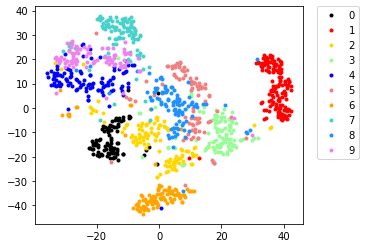

In [73]:
if encoder(torch.randn(3, 1, 28, 28).to(device))[0].shape == torch.Size([3, 10]):
    tests.visualize_embeddings(lambda x: encoder(x)[0], trainloader, n_samples=1000, device=device)

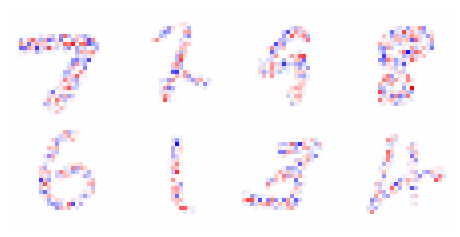

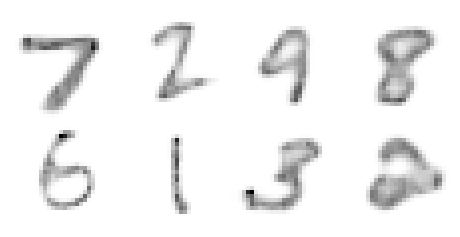

In [74]:
# In this cell, we visualize predictive variances of the model for each pixel.
# For a well-trained VAE, the variances should capture the shapes of the digits.
with torch.no_grad():
    dataiter = iter(trainloader)
    images, _ = next(dataiter)
    z_mean, z_logvar = encoder(images.to(device))
    y_mean, y_logvar = decoder(z_mean)

    # Visualize some data samples
    tools.show_images(images[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])
    # Visualize corresponding predictive variance in the pixel space
    tools.show_images(torch.exp(y_logvar[:8]), ncol=4, cmap='binary')

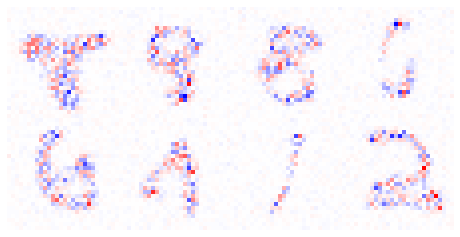

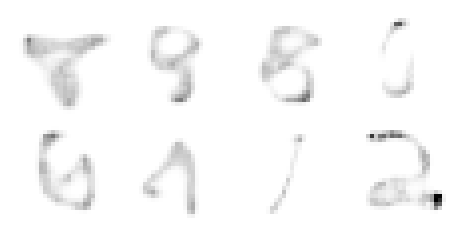

In [75]:
# Generate samples from VAE
# Note that samples may not be of great quality.
with torch.no_grad():
    z = torch.randn((8, 10)).to(device)
    x_mean, x_logvar = decoder(z)
    x = x_mean + torch.exp(0.5 * x_logvar) * torch.randn_like(x_logvar)
    tools.show_images(x[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])
    tools.show_images(torch.exp(x_logvar[:8]), ncol=4, cmap='binary')

# Test the quality of the produced embeddings by classification

We will test the quality of the produced encodings by training a classifier using the encoded images.

In [76]:
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [77]:
# Encode data samples using the VAE encoder
@torch.no_grad()
def encode(dataset, encoder):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    embeddings = []
    labels = []
    for images, labels_ in dataloader:
        mu, logsigma = encoder(images.to(device))
        embeddings.append(mu)
        labels.append(labels_)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

In [78]:
# Save and submit the VAE embeddings
if not skip_training:
    traincodes, trainlabels = encode(trainset, encoder)  # traincodes is (60000, 10)
    testcodes, testlabels = encode(testset, encoder)  # testcodes is (10000, 10)
    torch.save([traincodes, trainlabels, testcodes, testlabels], '3_vae_embeddings.pth')
else:
    traincodes, trainlabels, testcodes, testlabels = torch.load('3_vae_embeddings.pth', map_location=lambda storage, loc: storage)

In [79]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter=400)
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

# Compute accuracy of the linear classifier
accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .8, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')

Accuracy with a linear classifier: 87.44%
Success


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we trained a variational autoencoder on a dataset in which useful information is in the variance of the pixel values and not the pixel values themselves. The code produced by the encoder of the VAE is only $10$-dimensional compared to the original $28 \times 28 = 784$-dimensional data. Still, the codes capture well the shapes of the digits.